<a href="https://colab.research.google.com/github/PratyushNag/Music-Generator-v1/blob/main/Music_Generation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting Data

In [ ]:
from google.colab import files
! pip install -q kaggle
#upload kaggle.json
files.upload()

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d imsparsh/lakh-midi-clean
#!kaggle datasets download -d soumikrakshit/classical-music-midi

In [ ]:
! mkdir Midi
! unzip lakh-midi-clean.zip -d Midi
#! unzip classical-music-midi.zip -d Midi_classical

# Installing dependencies and imports

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
!pip install display

In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import pretty_midi
import fluidsynth
from IPython.display import display, Audio
import collections
from typing import Optional
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.layers import Dense, LSTM, Dropout, MaxPooling1D, Flatten, AveragePooling1D, AveragePooling2D, MaxPooling2D
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [16]:
#setting seed for randomness
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Data Munging

Mapping the data onto a dataframe for easy viewing acess

In [110]:
paths = []
for dirname, _, filenames in os.walk('Midi_classical'):
    for filename in filenames:
        if filename.lower().endswith(".mid"):
            paths.append(os.path.join(dirname, filename))

In [111]:
midi_df = pd.DataFrame()
midi_df['midi'] = paths
midi_df.tail()

,midi
290,Midi_classical/beeth/elise.mid
291,Midi_classical/beeth/beethoven_opus90_1.mid
292,Midi_classical/beeth/waldstein_1.mid
293,Midi_classical/beeth/mond_3.mid
294,Midi_classical/beeth/mond_1.mid


In [115]:
midi_df.shape

(295, 1)

In [116]:
#converting a sample MIDI file into a playable file using the pretty midi library
pm = pretty_midi.PrettyMIDI(midi_df.loc[0, 'midi'])

In [117]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display(Audio(waveform_short, rate=_SAMPLING_RATE))

In [118]:
display_audio(pm)

In [119]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 2
Instrument name: Acoustic Grand Piano


In [120]:
# function to convert MIDI file into it's specific notes, so its easier for user to view
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        instrument = pm.instruments[0]
        notes = collections.defaultdict(list)

        # Sort the notes by start time
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        prev_start = sorted_notes[0].start
        #Here we split the data into three respective features
        #pitch = note pressed (represented in numerical format)
        #step = when the note is pressed, w.r.t the last note
        #duration = how long the note is pressed for
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start

        return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

    except Exception as e:
        print(f"Error processing file {midi_file}: {str(e)}")
        return None

In [121]:
raw_notes = midi_to_notes(midi_df.loc[0, 'midi'])
raw_notes.head()

,pitch,start,end,step,duration
0,62,0.000000,6.184252,0.000000,6.184252
1,61,0.859681,1.719912,0.859681,0.860231
2,60,1.719912,6.184252,0.860231,4.464340
3,57,2.598488,6.184252,0.878576,3.585764
4,54,3.500307,6.184252,0.901818,2.683946


In [122]:
#adding a column 'note' converting respective pitches into understandable music notes
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
raw_notes['note'] = get_note_names(raw_notes['pitch'])
raw_notes

,pitch,start,end,step,duration,note
0,62,0.000000,6.184252,0.000000,6.184252,D4
1,61,0.859681,1.719912,0.859681,0.860231,C#4
2,60,1.719912,6.184252,0.860231,4.464340,C4
3,57,2.598488,6.184252,0.878576,3.585764,A3
4,54,3.500307,6.184252,0.901818,2.683946,F#3
...,...,...,...,...,...,...
1312,70,233.443833,234.959751,0.000000,1.515918,A#4
1313,74,233.443833,234.959751,0.000000,1.515918,D5
1314,79,234.959751,236.475669,1.515918,1.515918,G5
1315,86,234.959751,236.475669,0.000000,1.515918,D6


## Visualising the given data

In [158]:
#function to plot a piano roll graph from the given MIDI file for visualization purposes
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

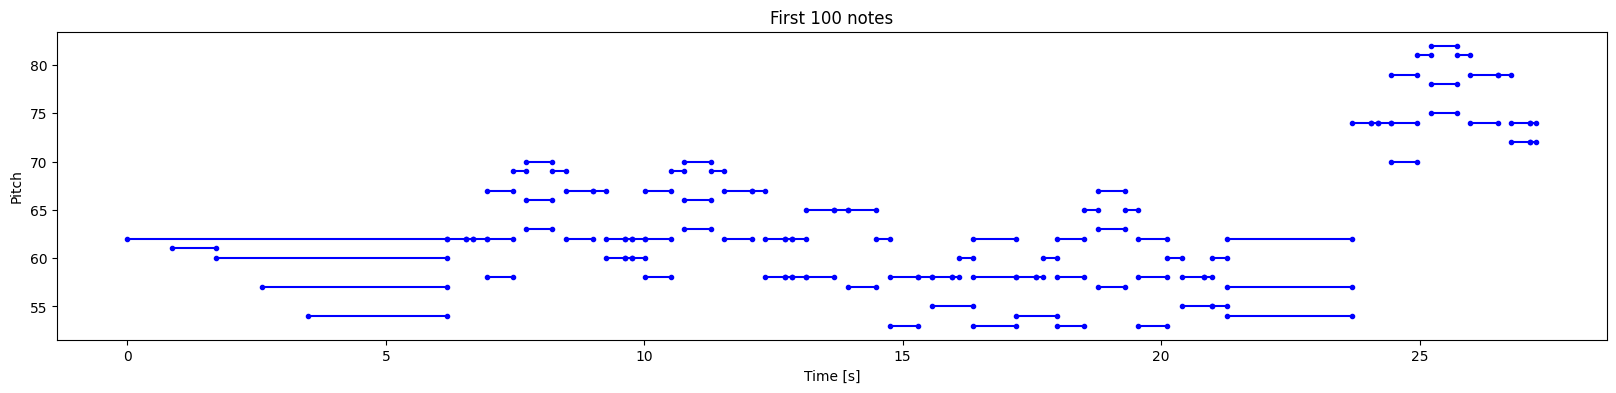

In [159]:
plot_piano_roll(raw_notes, count=100)

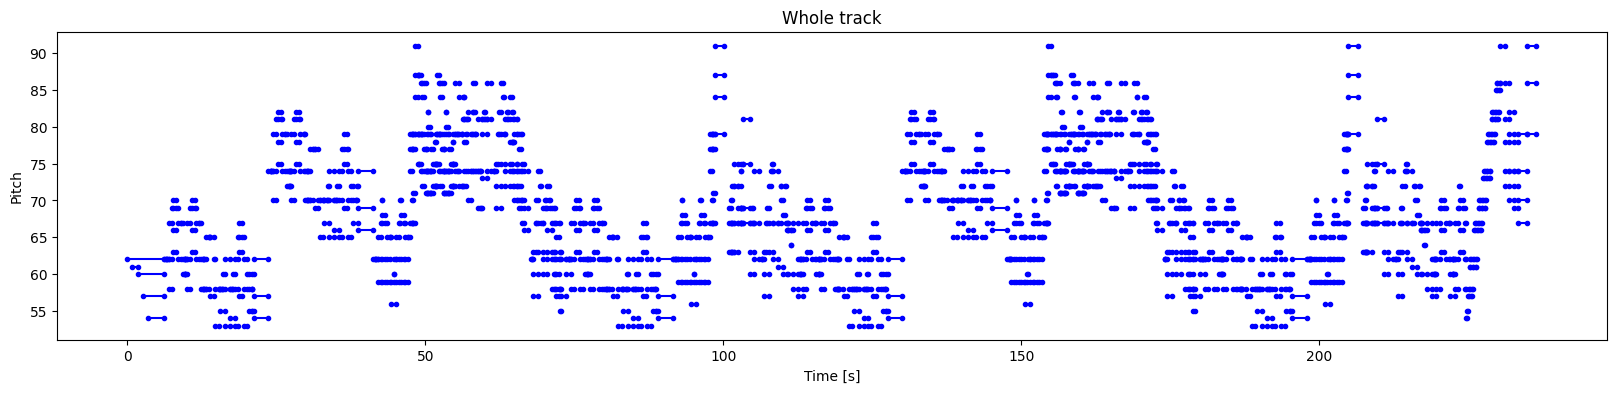

In [160]:
plot_piano_roll(raw_notes)

In [126]:
#function to plot the histogram  ditrubutions of pitch, duration and step
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

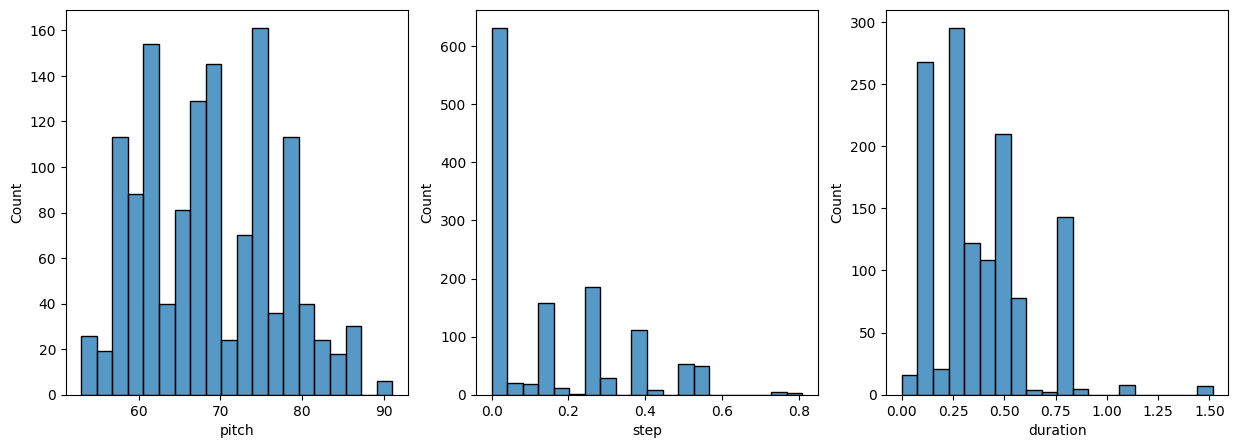

In [127]:
plot_distributions(raw_notes)

#Data Cleaning
converting the previous data into usable data using the pretty midi library to convert files into a trainable format, also dropping values that have corruptions or errors.

In [129]:
num_files = 50
all_notes = []
for f in paths[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [130]:
df = all_notes.dropna()
df

,pitch,start,end,step,duration
0,62,0.000000,6.184252,0.000000,6.184252
1,61,0.859681,1.719912,0.859681,0.860231
2,60,1.719912,6.184252,0.860231,4.464340
3,57,2.598488,6.184252,0.878576,3.585764
4,54,3.500307,6.184252,0.901818,2.683946
...,...,...,...,...,...
1414,88,158.201254,158.316448,0.115194,0.115194
1415,93,158.316448,158.440348,0.115194,0.123900
1416,81,158.440348,158.564248,0.123900,0.123900
1417,86,158.564248,158.688149,0.123900,0.123900


In [161]:
n_notes = len(df)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 41526


seperating the features to be trained on

In [132]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([df[key] for key in key_order], axis=1)

In [133]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [134]:
# function to split the given dataset into  equal sequences for better training performance, also dropping any incomplete sequences
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [135]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [136]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.484375   0.         6.18425225]
 [0.4765625  0.8596815  0.86023058]
 [0.46875    0.86023058 4.46434017]
 [0.4453125  0.87857633 3.58576383]
 [0.421875   0.90181833 2.6839455 ]
 [0.484375   2.6839455  0.3763485 ]
 [0.484375   0.3763485  0.1254495 ]
 [0.484375   0.1254495  0.2640615 ]
 [0.484375   0.2640615  0.50163   ]
 [0.453125   0.         0.50163   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=62.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.2626740000000005>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.4993759999999998>}


Creating the training data

In [138]:
batch_size = 128
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [139]:
train_ds.element_spec

(TensorSpec(shape=(128, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(128,), dtype=tf.float64, name=None)})

Defining a custom loss function to measure loss

In [140]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Defining and compiling the model

In [95]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x_in = Sequential([
    LSTM(128, return_sequences=False, input_shape=input_shape),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='linear')
])
x = x_in(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 25, 3)]              0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 3)                    76035     ['input_13[0][0]']            
                                                                                                  
 duration (Dense)            (None, 1)                    4         ['sequential_10[0][0]']       
                                                                                                  
 pitch (Dense)               (None, 128)                  512       ['sequential_10[0][0]']       
                                                                                            

In [141]:
losses = model.evaluate(train_ds, return_dict=True)
losses

324/324 [==============================] - 16s 29ms/step - loss: 0.2334 - duration_loss: 0.0944 - pitch_loss: 3.0950 - step_loss: 0.0462


{'loss': 0.2334156036376953,
 'duration_loss': 0.09436537325382233,
 'pitch_loss': 3.095043897628784,
 'step_loss': 0.046198926866054535}

reduce any inconsistencies in loss, by tuning loss weights below

In [145]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.003,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [146]:
model.evaluate(train_ds, return_dict=True)

324/324 [==============================] - 13s 34ms/step - loss: 0.1498 - duration_loss: 0.0944 - pitch_loss: 3.0950 - step_loss: 0.0462


{'loss': 0.14984947443008423,
 'duration_loss': 0.09436537325382233,
 'pitch_loss': 3.095043897628784,
 'step_loss': 0.046198926866054535}

In [147]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True),
]

In [148]:
%%time
epochs = 15

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks =callbacks
)

Epoch 1/15
324/324 [==============================] - 23s 64ms/step - loss: 0.1994 - duration_loss: 0.1209 - pitch_loss: 3.5449 - step_loss: 0.0679
Epoch 2/15
324/324 [==============================] - 20s 62ms/step - loss: 0.2244 - duration_loss: 0.1319 - pitch_loss: 3.7018 - step_loss: 0.0813
Epoch 3/15
324/324 [==============================] - 20s 61ms/step - loss: 0.2146 - duration_loss: 0.1249 - pitch_loss: 3.5744 - step_loss: 0.0790
Epoch 4/15
324/324 [==============================] - 23s 71ms/step - loss: 0.2284 - duration_loss: 0.1355 - pitch_loss: 3.6655 - step_loss: 0.0819
Epoch 5/15
324/324 [==============================] - 21s 64ms/step - loss: 0.2184 - duration_loss: 0.1280 - pitch_loss: 3.5755 - step_loss: 0.0796
Epoch 6/15
324/324 [==============================] - 20s 63ms/step - loss: 0.2094 - duration_loss: 0.1215 - pitch_loss: 3.4784 - step_loss: 0.0774
Epoch 7/15
324/324 [==============================] - 20s 63ms/step - loss: 0.2016 - duration_loss: 0.1170 - pit

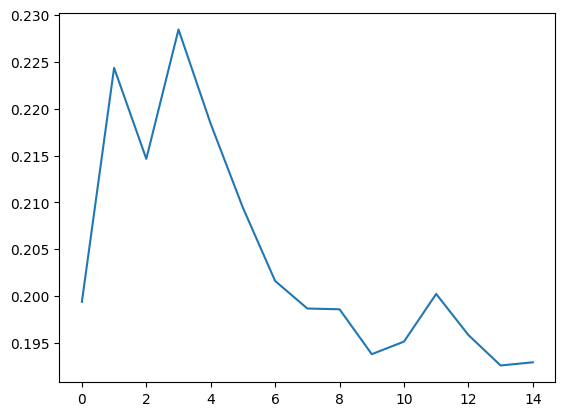

In [149]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [150]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [162]:
temperature = 1.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 26ms/step


In [152]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,63,0.283935,0.317541,0.283935,0.601476
1,89,0.101519,0.088991,0.385454,0.474446
2,83,0.360092,0.343520,0.745546,1.089066
3,91,0.306406,0.061355,1.051952,1.113307
4,93,0.267807,0.000000,1.319759,1.319759
5,93,0.267127,0.000000,1.586886,1.586886
6,82,0.267362,0.000000,1.854248,1.854248
7,88,0.266130,0.000000,2.120378,2.120378
8,85,0.269149,0.000000,2.389527,2.389527
9,95,0.270195,0.000000,2.659722,2.659722


In [153]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [154]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

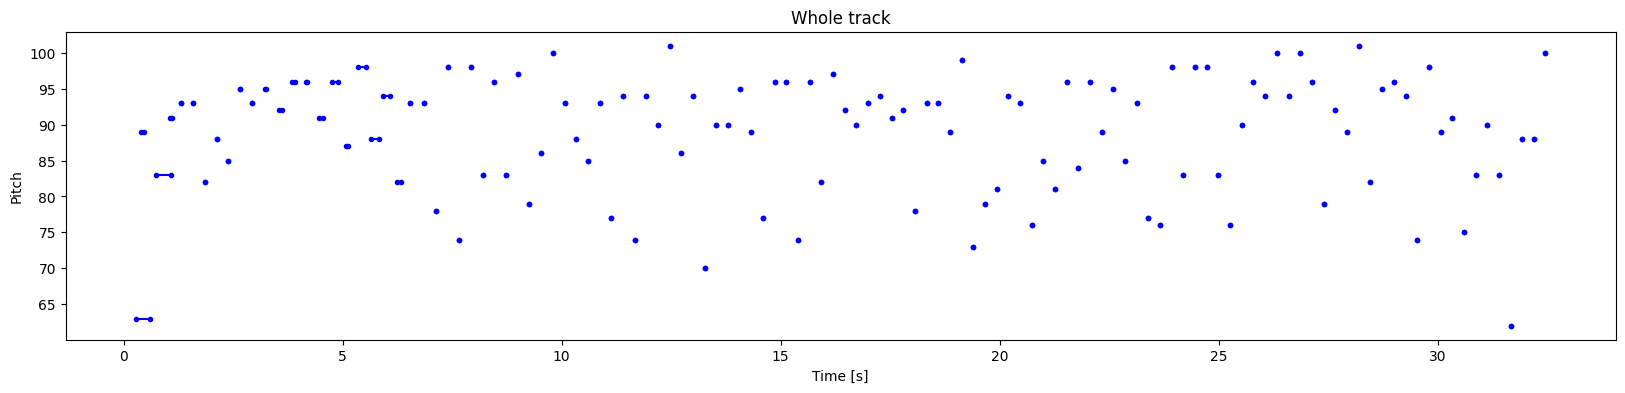

In [155]:
plot_piano_roll(generated_notes)

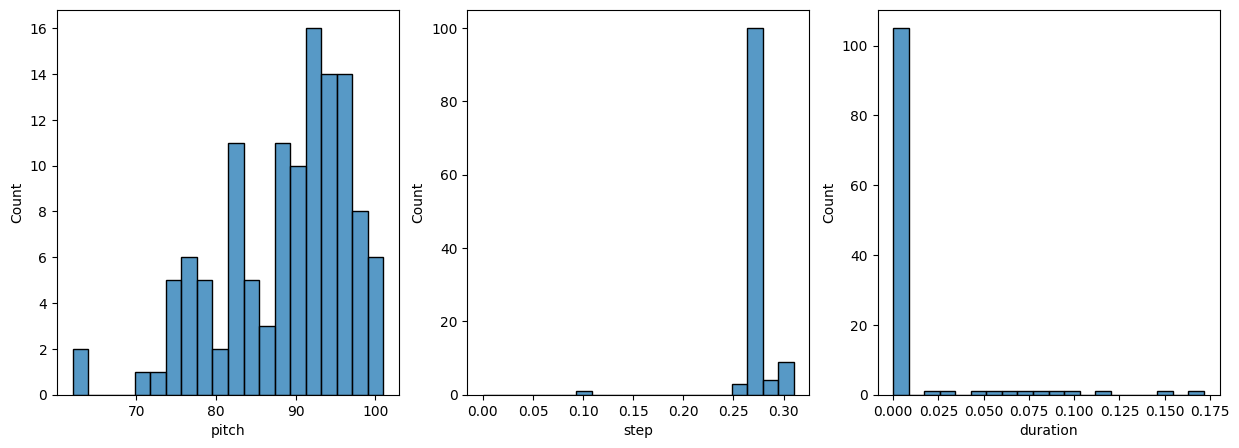

In [156]:
plot_distributions(generated_notes)

In [157]:
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>